In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import pickle
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from PIL import Image

import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications.vgg16 import VGG16,preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import to_categorical,plot_model
from tensorflow.keras.layers import Input,Dense,LSTM,Embedding,Dropout,add

import warnings
warnings.filterwarnings('ignore')


In [ ]:
Base_dir = '/content/drive/MyDrive/colab notebooks/Flicker_CNN/flickr8k'
working_dir = '/content/working/'

In [ ]:
# Read the CSV file (tab-separated)
df = pd.read_csv(f"{Base_dir}/captions.txt", delimiter="\t")
df.head()

,"image,caption"
0,"1000268201_693b08cb0e.jpg,A child in a pink dr..."
1,"1000268201_693b08cb0e.jpg,A girl going into a ..."
2,"1000268201_693b08cb0e.jpg,A little girl climbi..."
3,"1000268201_693b08cb0e.jpg,A little girl climbi..."
4,"1000268201_693b08cb0e.jpg,A little girl in a p..."


In [ ]:
df.shape

(40455, 1)

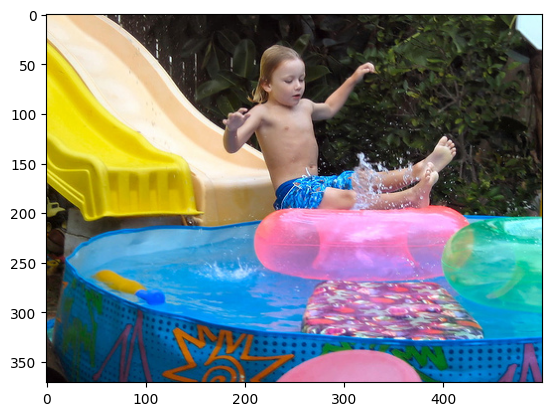

In [ ]:
## random image
image_name = "1077546505_a4f6c4daa9.jpg"
image_id = image_name.split('.')[0]
img_path = os.path.join(Base_dir, "Images", image_name)
image = Image.open(img_path)
plt.imshow(image)

In [ ]:
model=VGG16()
model=Model(inputs=model.inputs, outputs=model.layers[-2].output)
print(model.summary())

553467096/553467096 ━━━━━━━━━━━━━━━━━━━━ 7s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 4096)           │   102,764,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc2 (Dense)                     │ (None, 4096)           │    16,781,312 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 134,260,544 (512.16 MB)

 Trainable params: 134,260,544 (512.16 MB)

 Non-trainable params: 0 (0.00 B)

None


In [ ]:
features = {}

directory=os.path.join(Base_dir,'Images')
for img_name in tqdm(os.listdir(directory)):
    img_path = os.path.join(directory, img_name)

    if img_name.endswith(('.jpg', '.jpeg', '.png')):
        image = load_img(img_path, target_size=(224, 224))
        image = img_to_array(image)
        image = image.reshape(1, image.shape[0], image.shape[1], image.shape[2])
        image = preprocess_input(image)

        feature = model.predict(image, verbose=0)

        image_id = img_name.split('.')[0]

        features[image_id] = feature

print(f"Extracted features for {len(features)} images.")


  0%|          | 0/8091 [00:00<?, ?it/s]

Extracted features for 8091 images.


In [ ]:
features

{'1000268201_693b08cb0e': array([[2.5074754, 0.       , 0.       , ..., 0.       , 0.       ,
         0.       ]], dtype=float32),
 '1001773457_577c3a7d70': array([[0.        , 0.        , 0.49414784, ..., 0.        , 0.        ,
         0.        ]], dtype=float32),
 '1002674143_1b742ab4b8': array([[1.4937936, 0.       , 0.535675 , ..., 2.3152385, 3.741828 ,
         0.       ]], dtype=float32),
 '1003163366_44323f5815': array([[0., 0., 0., ..., 0., 0., 0.]], dtype=float32),
 '1007129816_e794419615': array([[0.        , 0.09227723, 0.        , ..., 0.        , 0.        ,
         0.06529003]], dtype=float32),
 '1007320043_627395c3d8': array([[0.       , 0.       , 0.       , ..., 0.       , 3.3390148,
         0.       ]], dtype=float32),
 '1009434119_febe49276a': array([[2.0965166, 2.1192532, 3.5619884, ..., 0.6424285, 2.7142017,
         0.       ]], dtype=float32),
 '1012212859_01547e3f17': array([[0.       , 0.       , 0.987371 , ..., 0.       , 1.4932511,
         0.8612851]],

## Text Preprocessing

In [ ]:
with open(os.path.join(Base_dir, 'captions.txt'), 'r') as File:
    next(File)
    caption_file = File.read()

In [ ]:
mapping = {}
for line in tqdm(caption_file.split('\n')):
    tokens = line.split(',')
    if len(line) < 2:
        continue
    image_id, caption = tokens[0], tokens[1:]
    image_id = image_id.split('.')[0]
    caption = " ".join(caption)

    if image_id not in mapping:
        mapping[image_id] = []
    mapping[image_id].append(caption)

  0%|          | 0/40456 [00:00<?, ?it/s]

In [ ]:
## Preprocessing of Text

def preprocessing(mapping):
    for key, captions in mapping.items():
        for i in range(len(captions)):
            caption = captions[i].lower()
            caption = caption.replace('[^A-Za-z]', '')
            caption = caption.replace('\s+', '')
            caption = 'startseq '+" ".join([word for word in caption.split() if len(word)>1]) + ' endseq'
            captions[i] = caption

preprocessing(mapping)

## Tokenization - Convert Text into Vectors

In [ ]:
all_captions = [caption for key in mapping for caption in mapping[key]]

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)

vocab_size = len(tokenizer.word_index) + 1
max_length = max(len(caption.split()) for caption in all_captions)

In [ ]:
print(vocab_size)
print(max_length)

8485
35


## Splitting data into train and test

In [ ]:
# get the image ids
image_ids = list(mapping.keys())

train, test = train_test_split(image_ids, test_size = 0.1, random_state = 42)

## Data Generation (To Avoid the Memory Issue)

In [ ]:
def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):

    X1, X2, y = [], [], []
    n = 0
    while True:
        for key in data_keys:
            captions = mapping[key]
            for caption in captions:
                seq = tokenizer.texts_to_sequences([caption])[0]
                for i in range(1, len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    in_seq = pad_sequences([in_seq], maxlen = max_length)[0]
                    out_seq = to_categorical([out_seq], num_classes = vocab_size)[0]
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
            n += 1
            if n == batch_size:
                yield {"image": np.array(X1), "text": np.array(X2)}, np.array(y)
                X1.clear()
                X2.clear()
                y.clear()
                n = 0

## Model Architecture

In [ ]:
# image feature layer
# 4096 neurons is the out of the seconf fc layer of vgg16

input1 = Input(shape=(4096, ), name = 'image')
a = Dropout(0.3)(input1)
X = Dense(256, activation = 'relu')(a)


# Sequence feature layer
input2 = Input(shape = (max_length,), name = 'text')
b = Embedding(vocab_size, 256)(input2)
d = Dropout(0.3)(b)
Y = LSTM(256)(d)


decoder1 = add([X, Y])
decoder2 = Dense(256, activation = 'relu')(decoder1)
outputs = Dense(vocab_size, activation = 'softmax')(decoder2)


model = Model(inputs = [input1, input2], outputs = outputs)
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam')

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ text (InputLayer)   │ (None, 35)        │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ image (InputLayer)  │ (None, 4096)      │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 35, 256)   │  2,172,160 │ text[0][0]        │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 4096)      │          0 │ image[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 35, 256)   │          0 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 256)       │  1,048,832 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 256)       │    525,312 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 256)       │          0 │ dense[0][0],      │
│                     │                   │            │ lstm[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 256)       │     65,792 │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 8485)      │  2,180,645 │ dense_1[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 5,992,741 (22.86 MB)

 Trainable params: 5,992,741 (22.86 MB)

 Non-trainable params: 0 (0.00 B)

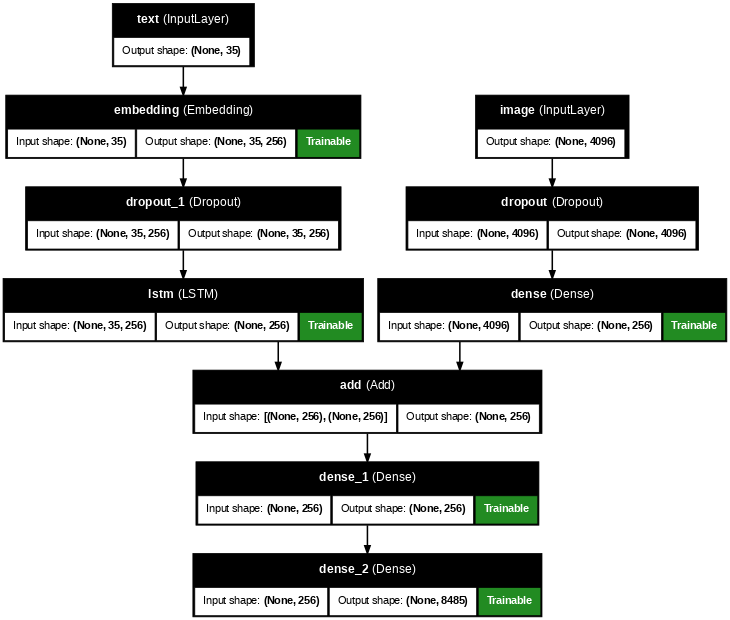

In [ ]:
tf.keras.utils.plot_model(
    model,
    to_file='/content/drive/MyDrive/colab notebooks/Flicker_CNN/model.png',
    show_shapes=True,
    show_dtype=False,
    show_layer_names=True,
    dpi=55,
    show_layer_activations=False,
    show_trainable=True
)

## Traing the model

In [ ]:
epochs = 15
batch_size = 32
steps = len(train)//batch_size

for i in range(epochs):
    generator = data_generator(train, mapping, features, tokenizer, max_length, vocab_size, batch_size)
    model.fit(generator, epochs = 1, steps_per_epoch = steps, verbose =1)

227/227 ━━━━━━━━━━━━━━━━━━━━ 77s 311ms/step - loss: 5.7699
227/227 ━━━━━━━━━━━━━━━━━━━━ 69s 302ms/step - loss: 4.0225
227/227 ━━━━━━━━━━━━━━━━━━━━ 69s 305ms/step - loss: 3.5382
227/227 ━━━━━━━━━━━━━━━━━━━━ 70s 309ms/step - loss: 3.2379
227/227 ━━━━━━━━━━━━━━━━━━━━ 70s 306ms/step - loss: 3.0233
227/227 ━━━━━━━━━━━━━━━━━━━━ 69s 305ms/step - loss: 2.8779
227/227 ━━━━━━━━━━━━━━━━━━━━ 70s 306ms/step - loss: 2.7771
227/227 ━━━━━━━━━━━━━━━━━━━━ 70s 306ms/step - loss: 2.6790
227/227 ━━━━━━━━━━━━━━━━━━━━ 72s 317ms/step - loss: 2.6017
227/227 ━━━━━━━━━━━━━━━━━━━━ 80s 349ms/step - loss: 2.5278
227/227 ━━━━━━━━━━━━━━━━━━━━ 77s 341ms/step - loss: 2.4614
227/227 ━━━━━━━━━━━━━━━━━━━━ 78s 341ms/step - loss: 2.4004
227/227 ━━━━━━━━━━━━━━━━━━━━ 74s 324ms/step - loss: 2.3479
227/227 ━━━━━━━━━━━━━━━━━━━━ 84s 368ms/step - loss: 2.3047
227/227 ━━━━━━━━━━━━━━━━━━━━ 84s 369ms/step - loss: 2.2656


## Generate Caption for the Image

In [ ]:
def convert_to_word(number, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == number:
            return word
    return None


def predict_caption(model, image, tokenizer, max_length):
    in_text = 'startseq'
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], max_length)
        y_pred = model.predict([image, sequence], verbose=0)
        y_pred = np.argmax(y_pred)
        word = convert_to_word(y_pred, tokenizer)
        if word is None:
            break
        in_text += " " + word
        if word == 'endseq':
            break

    return in_text

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt
def generate_caption(image_name):
    image_id = image_name.split('.')[0]
    img_path = os.path.join(Base_dir, "Images", image_name)
    image = Image.open(img_path)
    # predict the caption
    y_pred = predict_caption(model, features[image_id], tokenizer, max_length)
    print(y_pred)
    plt.imshow(image)

startseq little girl in pink walks with fingerpaints in front of painting endseq


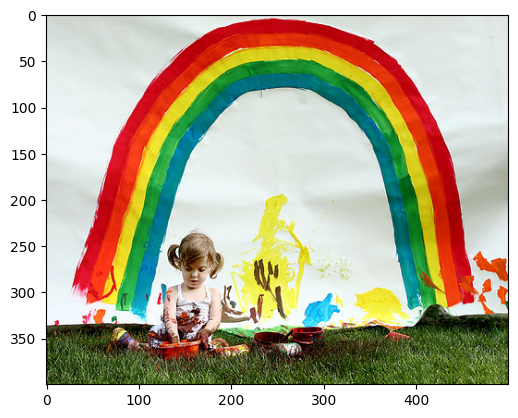

In [ ]:
generate_caption("1002674143_1b742ab4b8.jpg")

startseq young boy in blue shirt is sliding down blue slide endseq


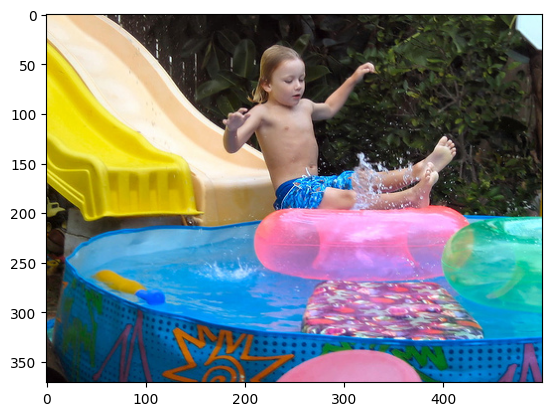

In [ ]:
generate_caption("1077546505_a4f6c4daa9.jpg")

startseq mottled black dog jumps over tree endseq


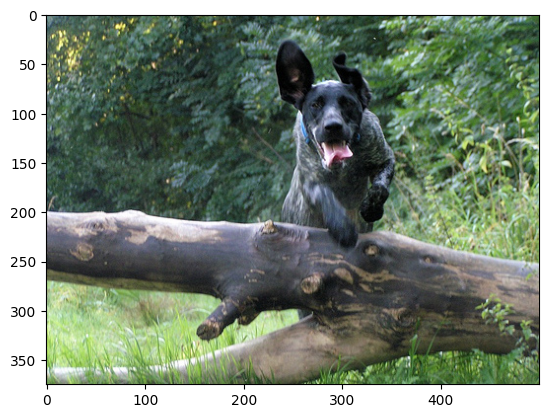

In [ ]:
generate_caption("1015584366_dfcec3c85a.jpg")

## Compute BLeU Score

In [ ]:
from nltk.translate.bleu_score import corpus_bleu
# validate with test data
actual, predicted = [] , []

for key in tqdm(test):

    captions = mapping[key]
    # predict the caption for image
    y_pred = predict_caption(model, features[key], tokenizer, max_length)
    # split into words
    actual_captions = [caption.split() for caption in captions]
    y_pred = y_pred.split()
    # append to the list
    actual.append(actual_captions)
    predicted.append(y_pred)

    # calcuate BLEU score
#Unigram
print("BLEU-1: %f" % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
#Bigram
print("BLEU-2: %f" % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))

  0%|          | 0/810 [00:00<?, ?it/s]

BLEU-1: 0.555133
BLEU-2: 0.336179


## Save the Model

In [ ]:
model.save('/content/drive/MyDrive/colab notebooks/Flicker_CNN/caption_generator_model.h5')

In [ ]:
pickle.dump(tokenizer , open('/content/drive/MyDrive/colab notebooks/Flicker_CNN/tokenizer.pkl','wb'))